## Analysis of the Redbridge property market.


*Data source:*

In [1]:
#import modin.pandas as mpd

In [2]:
##%%time
##data_postcode = mpd.read_csv('/Education/property_analysis/data/postcodes/postcodes.csv', low_memory=False)
#print('Loaded %s, %d records' % (len(data_postcode)))

In [39]:
%matplotlib inline
 
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request as req
from datetime import date
import json
import numpy as np
import sys
import seaborn as sns
import time
import calendar
import datetime 
import folium  
import os

from geopy.geocoders import Nominatim
from folium.plugins import HeatMap


from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 6)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'sans-serif'
rcParams['axes.facecolor'] = '#ffffff'  
rcParams['lines.linewidth'] = 2.0


from IPython.display import HTML
plt.style.use('seaborn-whitegrid')
      

In [4]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [5]:
#['IG1','IG2','IG3','IG4','IG5','IG6'] 
#= ['E4','E10','E11','E17']
#= ['NG2','NG5','NG7','NG11','NG8']

start_date = date(date.today().year -2, 1, 1).strftime('%Y-%m-%d')
end_date = date(date.today().year, 12, 31).strftime('%Y-%m-%d')


#print(start_date[:4],end_date)

In [6]:
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trimStrings = lambda x: x.strip() if type(x) is str else x
    df_out = df.applymap(trimStrings)
    return df_out

def set_property_type(df,lookup):
    """
    Translate property type acronyms  
    D: Detached
    S: Semi-detached
    T: Terraced
    F: Flat/maisonette
    O: Other
    """
    df_out = df['property_type'].map(lookup)
    return df_out

def missig_data(data):
    """
    Return missing data
    """
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

def monthly_sales(df):
    """
    Return count of monthly sales
    """
    df_out =  df['date_of_transfer'].str[5:7].astype(int).map(lambda x: calendar.month_abbr[x]).value_counts()
    return df_out

def filter_data(df, from_date, to_date):
    """
    Return data for given dates
    """
   
    df_out = df.loc[(df['date_of_transfer'] >= from_date) & (df['date_of_transfer'] < to_date)]
    return df_out
    
def remove_null_rows(df, col):
    """
    Drop nulls rows
    """
    out_df = df.loc[df[col].notnull()]
    out_df.reset_index(inplace = True, drop = True)
    return out_df

def query_latitude_longtitude(area):
    """
    Get latitude and longtitude for a given area
    return tuple
    """
    geolocator = Nominatim(user_agent="PROPPERTY PROJECT")
    city = area
    country = "Uk"
    loc = geolocator.geocode(city+','+ country)
    latitude = loc.latitude
    longtitude = loc.longitude    
    
    return (latitude,longtitude) 

In [7]:

directory = '/Education/property_analysis/data'
property_file = 'ppd_data_Ilford'
postcode_file = 'postcodes'
inflation_file = 'inflation'
suffix = 'csv'
postcode = ['IG1','IG2','IG3','IG4','IG5','IG6']


In [8]:
# Load in the land registry data table 
cols = ['transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', \
        'property_type', 'old/new','duration','PAON','SAON','Street','Locality', \
        'town/city','district','County','ppd_category_type','record_status_monthly_file_only']

file_path = os.path.join(directory, property_file + "." + suffix)

data = pd.read_csv(file_path,parse_dates=True,usecols=[0,1,2,3,4,9,11],names=cols)

# Exlude O "other" type of property data
data = data.loc[~data['property_type'].isin(['O','F'])]  

data['year'] = pd.DatetimeIndex(data['date_of_transfer']).year
data['month'] = pd.DatetimeIndex(data['date_of_transfer']).month

data['year'] = data['year'].astype(str).astype(int)
data['price'] = data['price'].astype(str).astype(int)
data['outcode'] = data['postcode'].str.split().str[0] 


In [9]:
lookup_type_values = {'D':'Detached','S':'Semi-detached','T':'Terraced','F':'Flat/maisonette','O':'Other'}
data['type']= set_property_type(data,lookup_type_values)

In [10]:
#%%time 
postcode_file = 'postcodes'
file_directory = os.path.join(directory, postcode_file + "." + suffix)

data_postcode = pd.read_csv(file_directory, low_memory=False)
print('Shape of data')
data_postcode.shape
#data_postcode.head()

Shape of data


(2611698, 44)

In [11]:
rename_columns = {'Postcode':'postcode','Latitude':'latitude','Longitude':'longitude','District':'area',\
                  'Distance to station': 'station_distance'}
data_postcode = data_postcode.rename(index=str, columns=rename_columns)

### Historic inflation figures.

In [12]:
file_directory = os.path.join(directory, inflation_file + "." + suffix)

data_inflation = pd.read_csv(file_directory)
data_inflation = data_inflation.rename(index=str, columns={'Year': 'year','Inflation Rate':'inflation_rate'})
data_inflation['inflation rate'] = data_inflation['inflation rate'].astype(float)
data_inflation['inflation rate']  = data_inflation['inflation rate'] * 100
data_inflation.tail(15)

,year,amount,inflation rate
145,2005,81.430108,2.824168
146,2006,84.032258,3.195563
147,2007,87.634409,4.286628
148,2008,91.129032,3.987730
149,2009,90.645161,-0.530973
150,2010,94.827957,4.614472
151,2011,99.763441,5.204672
152,2012,102.967742,3.211899
153,2013,106.096774,3.038847
154,2014,108.602151,2.361407


In [13]:
data = pd.merge(data_postcode, data, on='postcode', how='inner')
drop_columns = ['In Use?', 'Easting','Northing','Grid Ref','User Type',\
                'County Code','District Code','Ward Code','Terminated',\
                'Parish','Postcode district','National Park','Population','Postcode area',\
                'Introduced','Households','Ward','MSOA Code', 'Middle layer super output area',\
                'Lower layer super output area','Parish Code','Rural/urban','Built up area',\
                'Altitude','Police force','LSOA Code','Local authority', 'Census output area',\
               'Constituency Code','Region','Built up sub-division','Index of Multiple Deprivation',\
               'Quality','Country','Constituency','property_type']
data = data.drop(drop_columns, axis=1)
trim_all_columns(data)
data.columns

Index(['postcode', 'latitude', 'longitude', 'County', 'area', 'London zone',
       'Last updated', 'Nearest station', 'station_distance',
       'transaction_unique_identifier', 'price', 'date_of_transfer', 'Street',
       'town/city', 'year', 'month', 'outcode', 'type'],
      dtype='object')

### Missing property data

In [14]:
print(missig_data(data).head(10))

                  Total   Percent
Street                6  0.000142
type                  0  0.000000
Nearest station       0  0.000000
latitude              0  0.000000
longitude             0  0.000000
County                0  0.000000
area                  0  0.000000
London zone           0  0.000000
Last updated          0  0.000000
station_distance      0  0.000000


In [15]:
area = data['area'].unique()
area = area[0]


In [16]:

def load_json_response(url):
    return json.loads(req.urlopen(url).read())['result']

def validate_postcode(postcode):
    url = 'https://api.postcodes.io/postcodes/{}/validate'.format(postcode)
    return load_json_response(url)

def query_postcode(postcode):
    url = 'https://api.postcodes.io/postcodes?q={}'.format(postcode)
    #print(url)
    return load_json_response(url)

def query_postcode_lon_lat(lon,lat):
    url = 'http://api.postcodes.io/postcodes?lon={}&lat={}'.format(lon,lat)
    #print(url)
    return load_json_response(url)



In [17]:
city = data['town/city'].dropna().unique()
city = ' '.join(city).capitalize()

Median price paid since 2019 = £ 465000
Mean price paid since 2019 = £ 477380


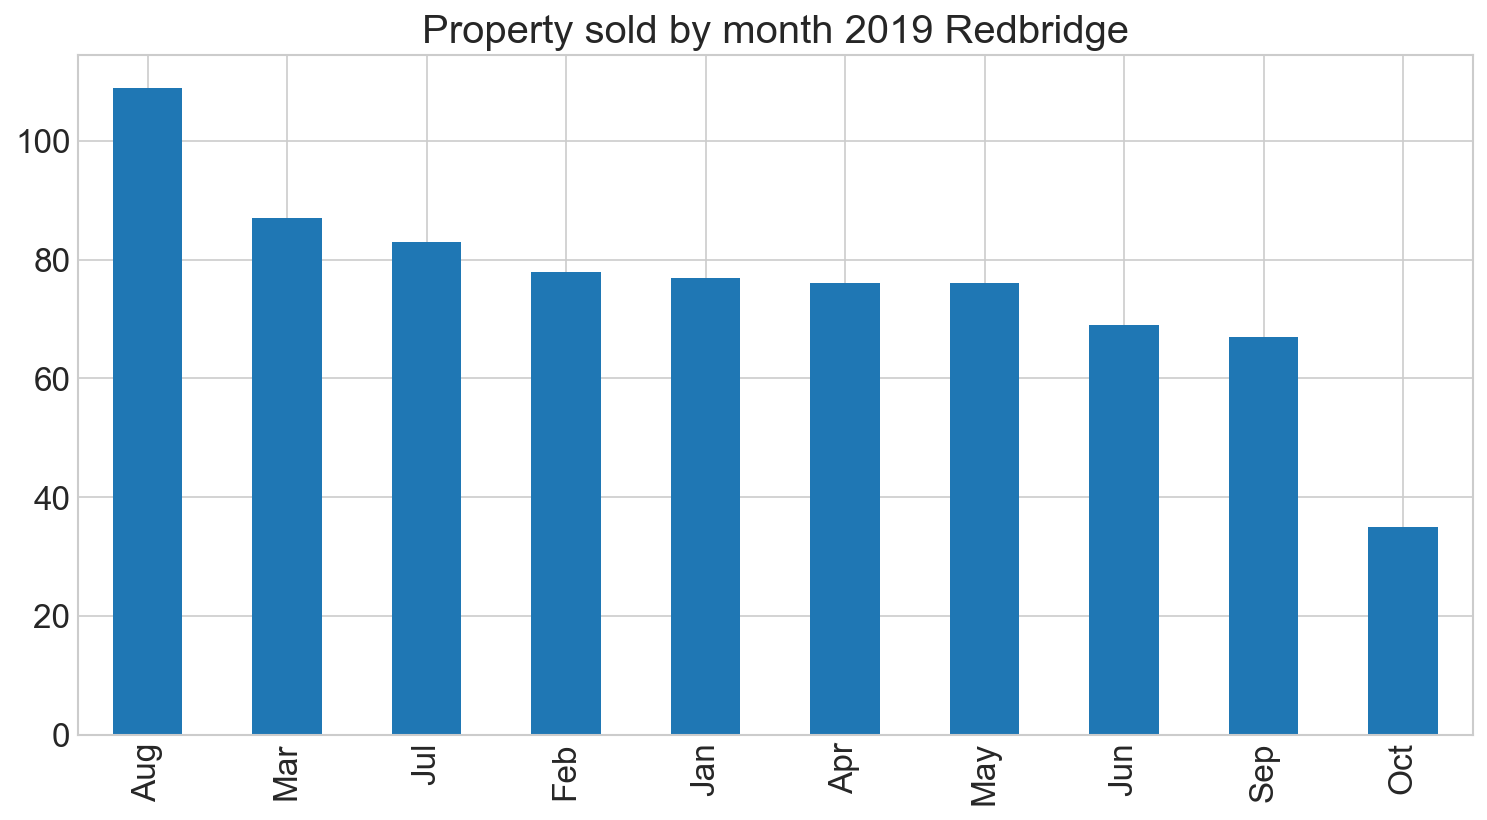

In [40]:
avg_start_date =date(date.today().year, 1, 1).strftime('%Y-%m-%d')
avg = filter_data( data,avg_start_date, end_date)

bar_title = "Property sold by month {0} {1}".format(avg_start_date[:4],area)
monthly_sales(avg).plot(x='date_of_transfer', kind='bar', title=bar_title)

print('Median price paid since 2019 = £ %d' % np.median(avg['price']))
print('Mean price paid since 2019 = £ %d' % np.mean(avg['price']))



In [19]:
df = filter_data(data, start_date, end_date)
twenty_percent = int(20/100 *len(df))

df_expensive = df.sort_values(by=['price'], ascending=False).head(twenty_percent)
df_expensive['cost'] = 'Expensive'


df_cheap = df.sort_values(by=['price'], ascending=True).head(twenty_percent)
df_cheap['cost'] = 'Cheap'

In [20]:
df = pd.concat([df_expensive, df_cheap], sort=False, ignore_index=True)


In [21]:
def plot_sales_price(df):
    # generate a new map latitude,longtitude
    latitude = query_latitude_longtitude(area)[0]
    longtitude = query_latitude_longtitude(area)[1]
    
    folium_map = folium.Map(location=[latitude ,longtitude],
                            zoom_start=13,
                            tiles="OpenStreetMap",
                            width='100%')

    # for each row in the data, add a cicle marker
    for index, row in df.iterrows():
                         
        popup_text = ''
                      
        # radius of circles
      
        if row["price"] >= 1000000:
            price = float((row["price"]/1000000))
            color="#8B0000" # drakred
            popup_text = "<br>Type:{} <br>Price:{}M"
            popup_text = popup_text.format(row["type"],price)           
        elif row["cost"] == 'Expensive':
            color="#008000" # 
            price = int((row["price"]/1000))
            popup_text = "<br>Type:{} <br>Price:{}K"
            popup_text = popup_text.format(row["type"],price)
        else:
            color="#0375B4" # 
            price = int((row["price"]/1000))
            popup_text = "<br>Type:{} <br>Price:{}K"
            popup_text = popup_text.format(row["type"],price)
        
        # add marker to the map
        folium.CircleMarker(location=(row["latitude"],
                                      row["longitude"]),
                            radius=5,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)
    return folium_map

In [22]:
print("Expensive top 20% in green and dark red, dark red also represents houses prices over a million.")
print("Cheapest 20% in blue.")
plot_sales_price(df)   

Expensive top 20% in green and dark red, dark red also represents houses prices over a million.
Cheapest 20% in blue.


In [23]:
folium_map = plot_sales_price(df)   
folium_map.save(area+ ".html")

In [53]:
def heat_map(df,latitude,longtitude):
    
    max_amount = float(df['price'].max())
    hmap = folium.Map(location=[latitude ,longtitude], zoom_start=13,  width='100%')

    hm_wide = HeatMap( list((df.latitude.values, df.longitude.values, df.price.values)),
                       min_opacity=0.2,
                       max_val=max_amount,
                       radius=17, blur=15, 
                       max_zoom=1, 
                     ).add_to(hmap)


    return hmap.add_child(hm_wide)
    
for_map =  filter_data(data, start_date, end_date)
latitude = query_latitude_longtitude(area)[0]
longtitude = query_latitude_longtitude(area)[1]

#heat_map(for_map,latitude,longtitude)



In [25]:
#folium_map =heat_map(for_map,latitude,longtitude)
#folium_map.save(area + "_heat_map.html")
#data.head()

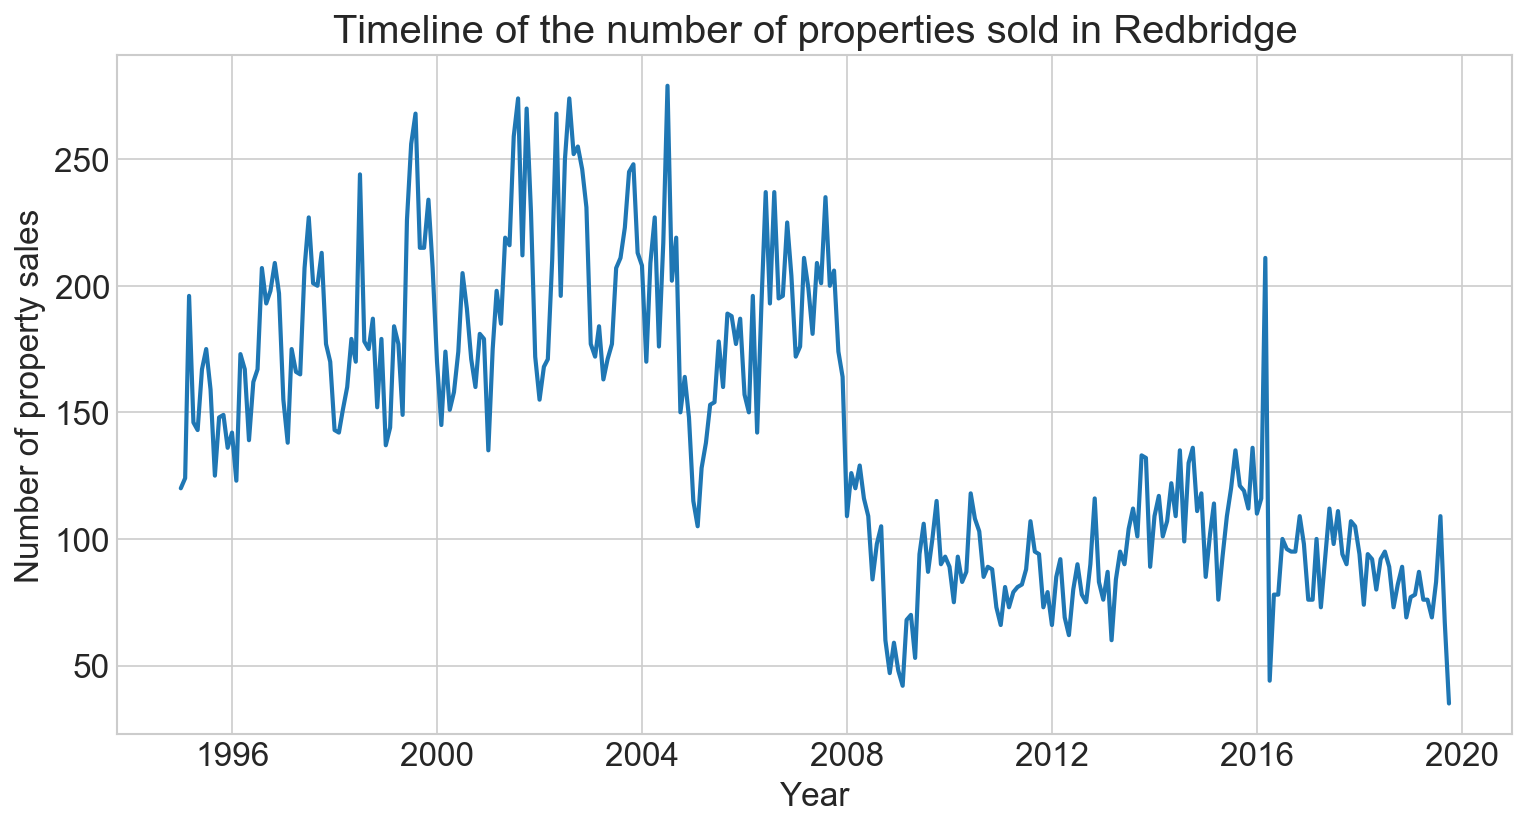

In [41]:
ts = data.groupby([(data['year']),(data['month'])])['transaction_unique_identifier'].count().reset_index()

ts['date'] = pd.to_datetime(ts.year.astype(str) + '-' + ts.month.astype(str))
 
fig, ax = plt.subplots()
ax.plot(ts['date'],ts['transaction_unique_identifier'])
plt.xlabel('Year')
plt.ylabel('Number of property sales')
ax.set_title('Timeline of the number of properties sold in {0}'.format(area))
plt.show()

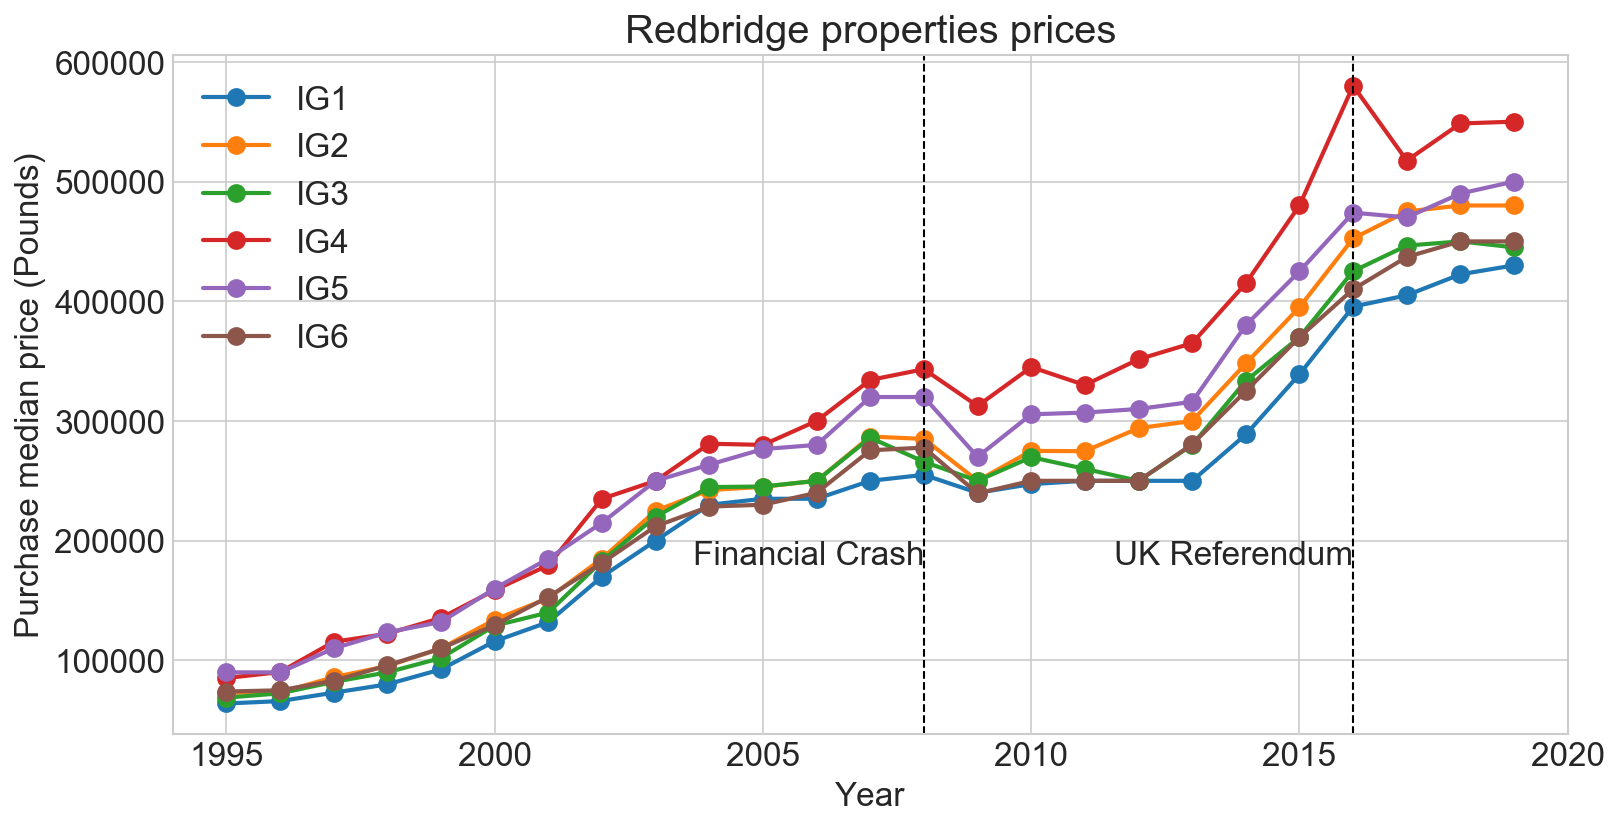

In [42]:
def get_median_price(data):
    return data.groupby(['year','outcode'])['price'].median().dropna().reset_index()

def get_by_postcode(data, postcode):
     return data.loc[data.outcode == postcode]

def plot_by_postcode(data):
    ax = plt.gca()
    data.plot(kind='line',x='year',y='price',ax=ax,linewidth=2, marker='o', markersize=8)
    #plt.plot(year_mean, linewidth=2, marker='o', markersize=8)
    

[plot_by_postcode(get_by_postcode(get_median_price(data),pc))for pc in postcode]
plt.xlim(1994,2020)

#for code in postcode:
    # plot_by_postcode(get_by_postcode(get_median_price(data),code))

plt.legend(postcode, loc='upper left')
        
# gca stands for 'get current axis'
plt.text(2008,180000,'Financial Crash',horizontalalignment='right')
plt.text(2016,180000,'UK Referendum',horizontalalignment='right')
plt.xlabel('Year')
plt.ylabel('Purchase median price (Pounds)')
plt.title("{0} properties prices".format(area))

plt.axvline(2008, color='k', linestyle='dashed', linewidth=1)
plt.axvline(2016, color='k', linestyle='dashed', linewidth=1)
plt.show()

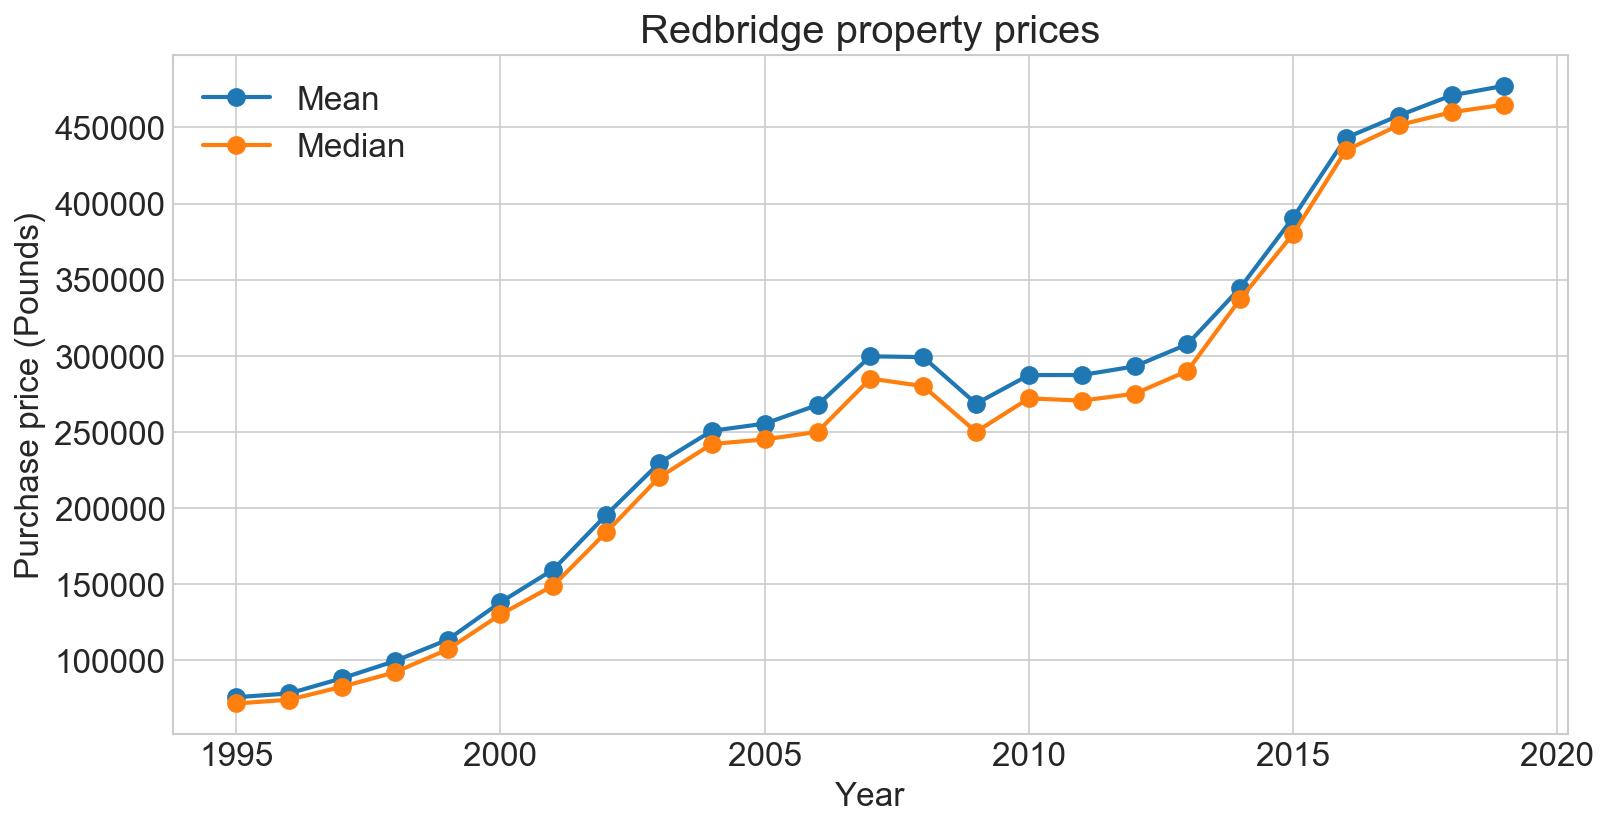

In [43]:
#plt.rcParams.update({'font.size': 8})

year_median = data['price'].groupby(data.year).aggregate(np.median)
year_mean = data['price'].groupby(data.year).aggregate(np.mean)
plt.plot(year_mean, linewidth=2, marker='o', markersize=8)
plt.plot(year_median, linewidth=2, marker='o', markersize=8)
plt.xlabel('Year')
plt.ylabel('Purchase price (Pounds)')
plt.title("{0} property prices".format(area))
plt.legend(['Mean', 'Median',], loc='upper left')
plt.show()

In [29]:
data = pd.merge(data, data_inflation, on='year', how='inner')


In [30]:
def percentage_change(df):
    df['price_change'] = (df.price - df.price.shift(1))/df.price * 100
    return df['price_change'] 


In [31]:
df = data.groupby(['year'])['price','inflation rate'].median().dropna().reset_index()
df.year = df.year.astype(int)
df = df.sort_values(['year'], ascending=[True])
df['price_change'] = percentage_change(df)

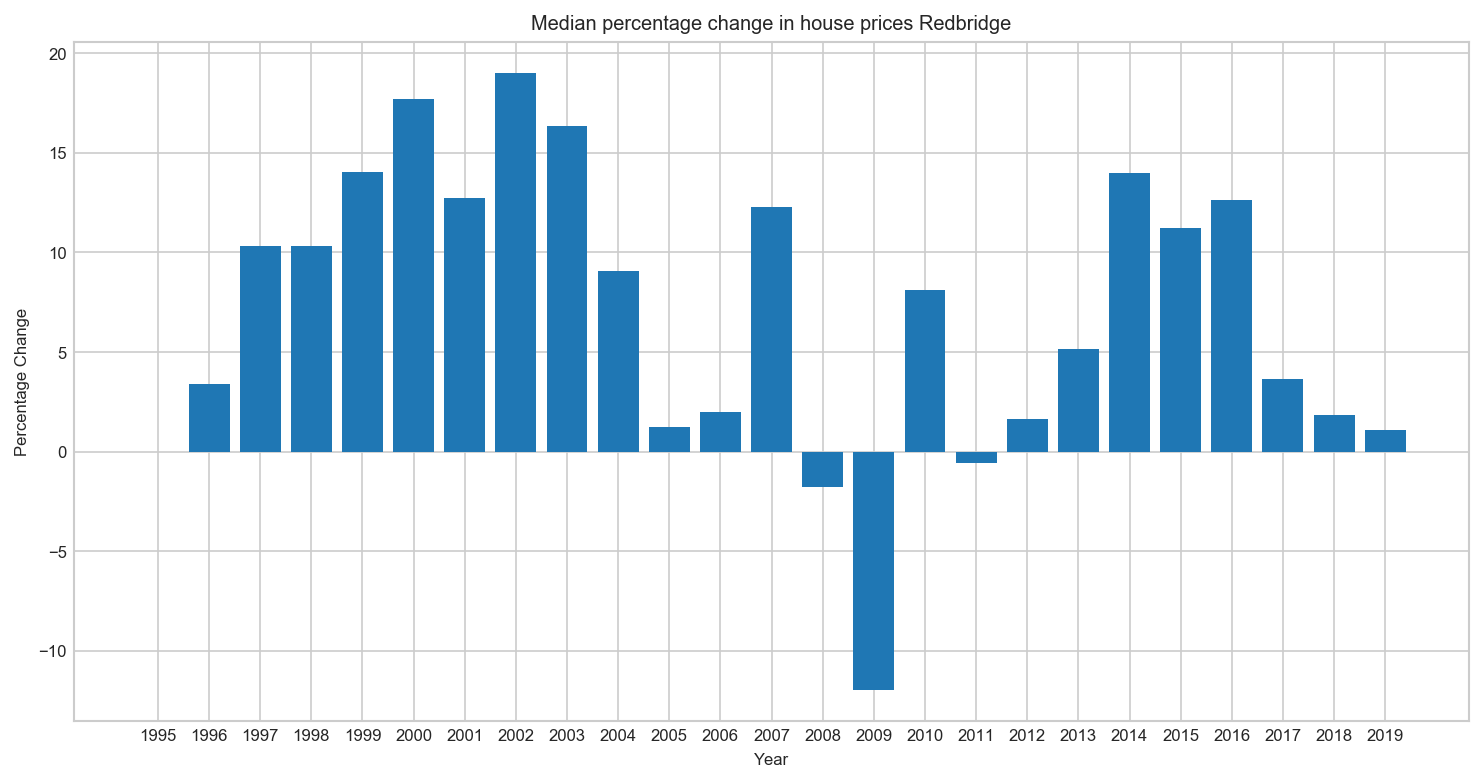

In [44]:
plt.rcParams.update({'font.size': 8})
objects = df['year'].unique()

y_pos = np.arange(len(objects))
performance = df['price_change']

plt.bar(y_pos, performance, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage Change')
plt.xlabel('Year')
plt.title('Median percentage change in house prices {0}'.format(area))
plt.show()

Text(0.5, 1.0, 'Sold price by postcode for 2019')

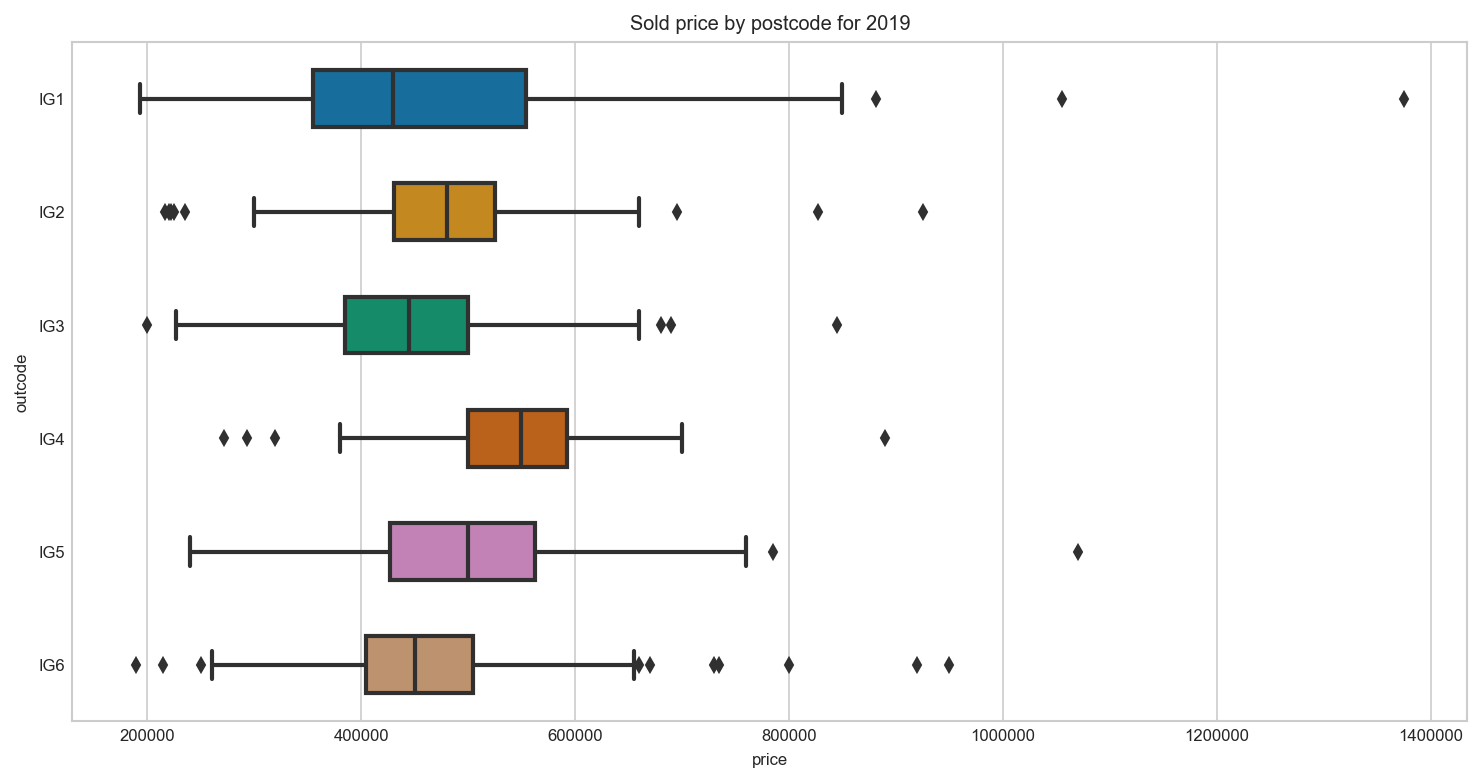

In [45]:
bplot=sns.boxplot(y='outcode', x='price', 
                 data=avg, 
                 width=0.5,
                 palette="colorblind")
plt.rcParams['figure.figsize']=(20,20)
bplot.set_title("Sold price by postcode for {0}".format(avg_start_date[:4]))

In [34]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

### House price change in Redbridge

In [35]:
df['price_change'] = df['price_change'].replace('nan', np.nan).fillna(0)

df.style.applymap(color_negative_red)
#df.price_change.apply(lambda x : "{:,}".format(x))
# df['cost'].map('{:,}'.format)
#data

,year,price,inflation rate,price_change
0,1995,71500,3.46526,0
1,1996,74000,2.41414,3.37838
2,1997,82500,3.13745,10.303
3,1998,92000,3.4283,10.3261
4,1999,107000,1.54062,14.0187
5,2000,130000,2.95785,17.6923
6,2001,149000,1.77136,12.7517
7,2002,184000,1.6674,19.0217
8,2003,220000,2.89167,16.3636
9,2004,242000,2.97819,9.09091


In [36]:
df_turnover = filter_data(data, start_date, end_date)
#df[['Street']].count()
#df = df.groupby('Street').count()
df_turnover = df_turnover.groupby(['postcode'])['Street'].describe().dropna().reset_index()
rename_columns = {'top':'street','freq':'frequency'}
df_turnover = df_turnover.sort_values(by='count', ascending=False)
df_turnover = df_turnover.rename(index=str, columns=rename_columns)
df_turnover = df_turnover[['street','postcode','frequency']].head(10)
print('Top 10 turnover streets, since',start_date[:4])
df_turnover.reset_index(drop=True)


Top 10 turnover streets, since 2017


,street,postcode,frequency
0,HUGHES ROAD,IG6 2FP,26
1,MARINE CRESCENT,IG6 2FJ,25
2,REPTON GROVE,IG5 0RN,14
3,WOODBURY CRESCENT,IG5 0FF,12
4,FULLWELL AVENUE,IG5 0FA,11
5,PEAKETON AVENUE,IG4 5PG,10
6,MOSSFORD LANE,IG6 2JA,8
7,GENAS CLOSE,IG6 2PJ,8
8,OAKHURST CLOSE,IG6 2LT,8
9,WANSTEAD PARK ROAD,IG1 3TT,8


In [37]:
df_price = filter_data(data, start_date, end_date)
df_price = pd.DataFrame(df_price.groupby(['Street'])['price'].agg(['median','mean','count']).reset_index())
df_price = df_price.sort_values(by='median', ascending=False)
df_price = df_price.rename(index=str, columns={'Street':'street','count':'number_sold'})
df_price = df_price[['street','median','number_sold']]
df_price['median'] = df_price['median'].map('{:,}'.format)
print('Top 10 most expensive streets, since',start_date[:4])
df_price.reset_index(drop=True).head(10)


Top 10 most expensive streets, since 2017


,street,median,number_sold
0,HOLCOMBE ROAD,"1,375,000.0",3
1,DOUGLAS CLOSE,"950,000.0",1
2,HAZEL LANE,"840,000.0",3
3,BETHELL AVENUE,"837,500.0",2
4,LORD AVENUE,"813,500.0",6
5,PETERBOROUGH GARDENS,"805,000.0",1
6,CHELMSFORD GARDENS,"787,500.0",2
7,TILLOTSON ROAD,"760,000.0",4
8,AMBER LANE,"750,000.0",1
9,EMPRESS AVENUE,"740,000.0",3


In [38]:
print('Top 10 cheapest streets, since', start_date[:4])
df_price.reset_index(drop=True).tail(10)

Top 10 cheapest streets, since 2017


,street,median,number_sold
639,DUNEDIN ROAD,"253,000.0",1
640,LYNTON CRESCENT,"252,000.0",1
641,HAWKESBURY CLOSE,"248,000.0",1
642,DE VERE GARDENS,"247,500.0",4
643,BENTLEY DRIVE,"225,000.0",1
644,OAKWOOD GARDENS,"215,000.0",1
645,BROADHURST AVENUE,"213,000.0",1
646,HUMPHREY CLOSE,"207,000.0",1
647,FALCONER ROAD,"198,050.0",2
648,CLANDON ROAD,"190,000.0",1
